In [1]:
from qiskit import Aer, execute, QuantumCircuit, QuantumRegister, ClassicalRegister, IBMQ
from qiskit.circuit import ParameterVector
from qiskit.quantum_info import Statevector
from qiskit.circuit.library import EfficientSU2
from qiskit.algorithms.optimizers import GradientDescent, ADAM
from scipy.optimize import minimize

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import cm
import time

In [2]:
def encode_data(data):
    num = np.ceil(np.log2(len(data)))
    size = int(2**num)
    encoded_data = []
    for i in range(len(data)):
        encoded_data.append([value_probabilities[feat_num[i]][data[i]]])
    for i in range(size - len(data)):
        encoded_data.append([0])
    norm = np.linalg.norm(encoded_data)
    return np.reshape(encoded_data/norm, size)

In [3]:
def ansatz(reps, N, thetas, measure=False):
    d = int(np.ceil(np.log2(N)))
    ckt = EfficientSU2(d, su2_gates=['ry', 'rz'], reps=reps, entanglement='linear', insert_barriers=False, skip_final_rotation_layer=True)
    params = ckt.ordered_parameters
    
    param_vals = {params[i]: thetas[i] for i in range(len(params))}

    ckt.assign_parameters(param_vals, inplace=True)
    if measure:
        ckt.measure_all()
    
    return ckt

In [4]:
def cost(thetas, N, data):
    ckt = ansatz(reps, N, thetas, False)
    prepared_state = Statevector.from_instruction(ckt).data    
    cst = 1 - np.square(np.abs(np.vdot(prepared_state, data)))
    
    # print(cst)
    return cst

In [5]:
features = {'class' : ['B', 'C', 'D', 'E', 'F', 'H'], 
            'spot-size-largest' : ['A', 'H', 'K', 'R', 'S', 'X'],
            'spot-distribution' : ['C', 'I', 'O', 'X'], 
            'activity' : ['1', '2'], 
            'evolution' : ['1', '2', '3'], 
            'activity-code' : ['1', '2', '3'], 
            'historically-complex' : ['1', '2'], 
            'complex-sun' : ['1', '2'], 
            'area' : ['1', '2'], 
            'area-largest' : ['1'],
#             'c-class' : ['0', '1', '2', '3', '4', '5', '6', '8'],
            'm-class' : ['0', '1', '2', '3', '4', '5'],
            'x-class' : ['0', '1', '2'],
           }

In [6]:
max_n = max([len(features[k]) for k in features])

In [7]:
def rootsofunity(phi):
    angles = np.linspace(phi, phi+(2*np.pi), max_n+1)
    angles = angles[:-1]
    angles = angles*(1j)
    roots = np.exp(angles)
#     roots = np.divide(np.exp(angles), np.sqrt(max_n))
    return roots

In [8]:
feat_num = {}
for i, feature in enumerate(features.keys()):
    feat_num[i] = feature

In [9]:
feature_probabilities = {}
i = 0
for feature in features.keys():
    probs = rootsofunity(i*2*np.pi/(max_n*len(features)))
    feature_probabilities[feature] = probs
    i += 1

In [10]:
value_probabilities = {}
for feature in features.keys():
    probs = {}
    for i, val in enumerate(features[feature]):
        probs[val] = feature_probabilities[feature][i]
    value_probabilities[feature] = probs

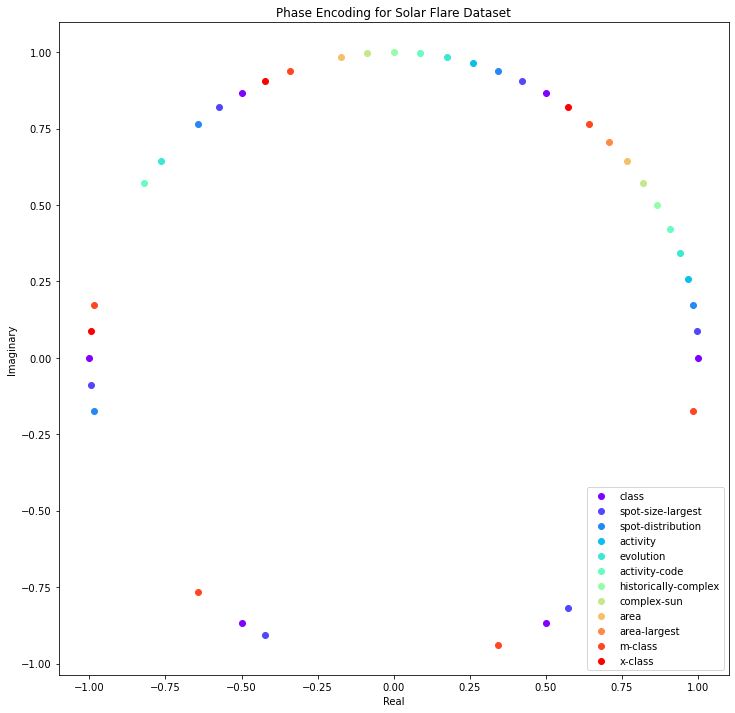

In [11]:
plt.figure(figsize=(12,12))
color = cm.rainbow(np.linspace(0, 1, 12))

c=0
for p in value_probabilities:
    D = value_probabilities[p]
    x_p = []
    y_p = []
    for k in D:
        x_p.append(D[k].real)
        y_p.append(D[k].imag)
    plt.scatter(x_p, y_p, label=p, color=color[c])
    c+=1

plt.xlabel("Real")
plt.ylabel("Imaginary")
plt.title("Phase Encoding for Solar Flare Dataset")
plt.axis("equal")

plt.legend()

In [12]:
solar_file = open("solar_flare.csv")
solar_data = solar_file.readlines()
    
solar_database = []
for data in solar_data[1:]:
    feature_vector = list(data.strip().split(","))
    solar_database.append(feature_vector[:10] + feature_vector[11:])

In [13]:
database = []
for data in solar_database:
    print(data)
    database.append(encode_data(data))

['H', 'A', 'X', '1', '3', '1', '1', '1', '1', '1', '0', '0']
['D', 'R', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['C', 'S', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['H', 'R', 'X', '1', '2', '1', '1', '1', '1', '1', '0', '0']
['H', 'S', 'X', '1', '1', '1', '1', '2', '1', '1', '0', '0']
['C', 'A', 'O', '1', '2', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['C', 'A', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['C', 'A', 'O', '1', '2', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['C', 'A', 'O', '1', '2', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'I', '1', '2', '1', '1', '2', '1', '1', '0', '0']
['C', 'S', 'O', '2', '2', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'O', '1', '3', '1', '1', '2', '1', '1', '0', '0']
['B', 'X', 'O', '1', '2', '1', '1', '2', '1', '1', '0', '0']
['D', 'R', 'I', '1', '3'

In [17]:
def prep_circ(params, N):
    ckt = ansatz(reps, N, params[:-1])
    global_phase = params[-1]
    ckt.p(global_phase, 0)
    ckt.x(0)
    ckt.p(global_phase, 0)
    ckt.x(0)
    return ckt

In [18]:
def get_params(data):
    N = len(data)
    d = int(np.ceil(np.log2(len(data))))
    num_params = 2*d*reps
    
    init_theta = [np.random.uniform(-np.pi, np.pi) for i in range(num_params)]
    ckt = ansatz(reps, N, init_theta)
    print(cost(init_theta, N, data))
    
    res = minimize(cost, init_theta, args=(N, data), method='BFGS')
    
    theta = res.x
    ckt = ansatz(reps, N, theta, False)
    sv = Statevector.from_instruction(ckt)
    prepared_data = sv.data
    
    global_phase = np.angle(data)[0]  - np.angle(prepared_data)[0]
    
    return list(theta) + [global_phase]

# Experiments

In [49]:
reps = 5
cp = []
times = []
for i, data in enumerate(database[749:750]):
    st = time.time()
    ckt_params = get_params(data)
    et = time.time()
    cp.append(ckt_params)
    times.append(et-st)

0.9640271970451288


In [50]:
ckt_1 = prep_circ(cp[0], 16)
sv_1 = Statevector.from_instruction(ckt_1).data

In [95]:
cost(cp[0], 16, database[749])

3.983823493314276e-09

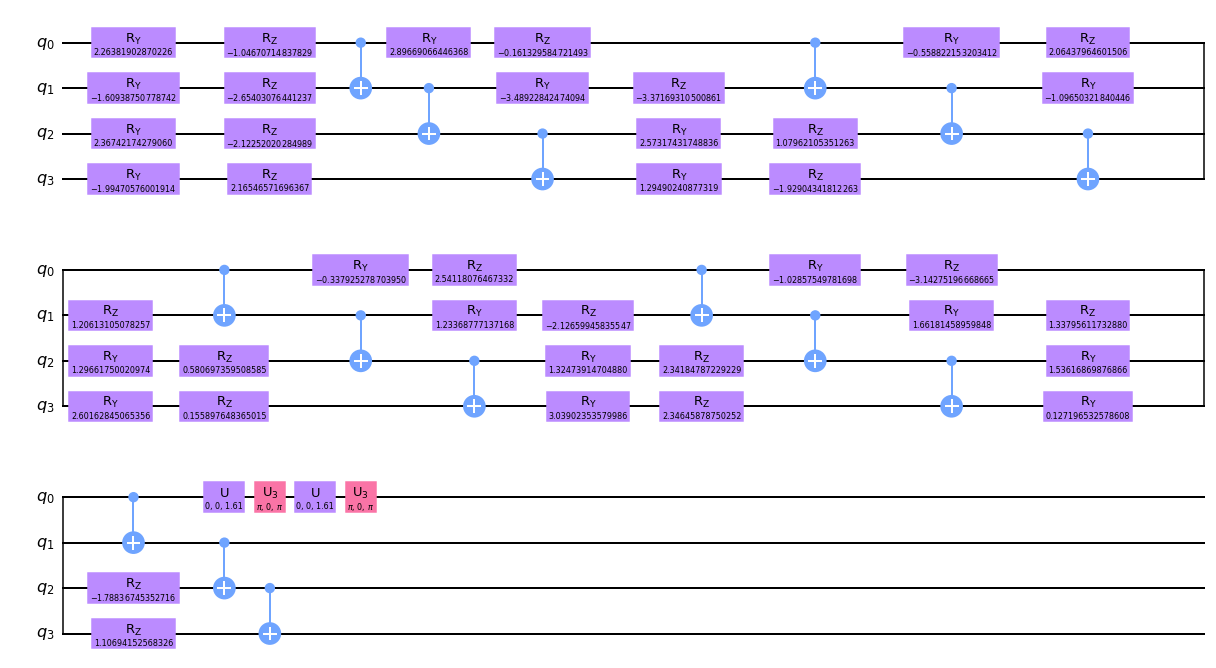

In [52]:
ckt_1.decompose().draw('mpl')

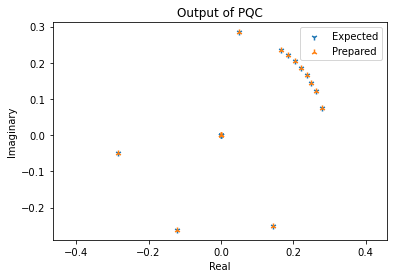

In [92]:
x_data = database[749].real
y_data = database[749].imag

x_prep = sv_1.real
y_prep = sv_1.imag

plt.scatter(x_data, y_data, marker="1", label="Expected")
plt.scatter(x_prep, y_prep, marker="2", label="Prepared")

plt.ylabel('Imaginary')
plt.xlabel('Real')

plt.title("Output of PQC")

plt.axis('equal')
plt.legend()

Text(0, 0.5, '$Angle_i$')

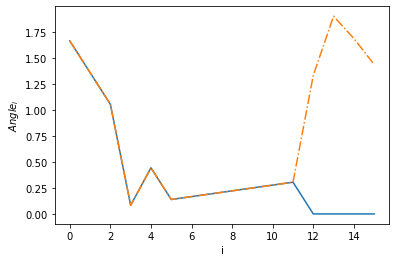

In [89]:
p_angles = np.angle(database[749])/np.pi
p_angles = np.mod(p_angles, 2)
p_prep_angles = np.angle(sv_1)/np.pi
p_prep_angles = np.mod(p_prep_angles, 2)

plt.plot(p_angles)
plt.plot(p_prep_angles, "-.")

plt.xlabel("i")
plt.ylabel(f"$Angle_i$")

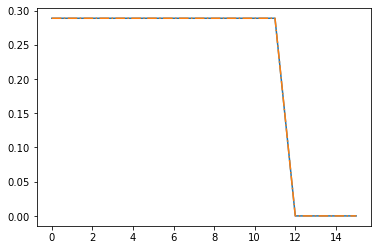

In [59]:
p_amps = np.abs(database[749])
p_prep_amps = np.abs(sv_1)

plt.plot(p_amps)
plt.plot(p_prep_amps, "-.")

***